# Week 13 - Ensemble Learning and Random Forest

The following is adapted from **Chapter 7 of Hands-on Machine Learning** book. Please refer to Chapter 6 of the Hands-on Machine Learning book, accessible via the link provided in the course outline.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)


# Scikit-Learn ≥ 1.0.1:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ensembles` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ensemble Learning

Suppose you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the `wisdom of the crowd`. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an `ensemble`; thus, this technique is called `ensemble learning`, and an ensemble learning algorithm is called an ensemble method.

As an example of an ensemble method, you can train a group of decision tree classifiers, each on a different random subset of the training set. You can then obtain the predictions of all the individual trees, and the class that gets the most votes is the ensemble’s prediction (see the last exercise in Chapter 6). Such an ensemble of decision trees is called a random forest, and despite its simplicity, this is one of the most powerful machine learning algorithms available today.

As discussed in Chapter 2, you will often use ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor. In fact, the winning solutions in machine learning competitions often involve several ensemble methods—most famously in the [Netflix Prize competition](https://en.wikipedia.org/wiki/Netflix_Prize).

In this chapter we will examine the most popular ensemble methods, including voting classifiers, bagging and pasting ensembles, random forests, and boosting, and stacking ensembles.

# Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a logistic regression classifier, an SVM classifier, a random forest classifier, a k-nearest neighbors classifier, and perhaps a few more.


![Training Diverse Classifier](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0701.png)


A very simple way to create an even better classifier is to aggregate the predictions of each classifier: the class that gets the most votes is the ensemble’s prediction. This majority-vote classifier is called a hard voting classifier (see figure below)

![ Hard voting classifier predictions
](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0702.png)

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a _weak learner_ (meaning it does only slightly better than random guessing), the ensemble can still be a _strong learner_ (achieving high accuracy), provided there are a sufficient number of weak learners in the ensemble and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery. Suppose you have a slightly biased coin that has a 51% chance of coming up heads and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to _the law of large numbers_: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%). Figure 7-3 shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%.

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case because they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

---


**TIP**

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.


---





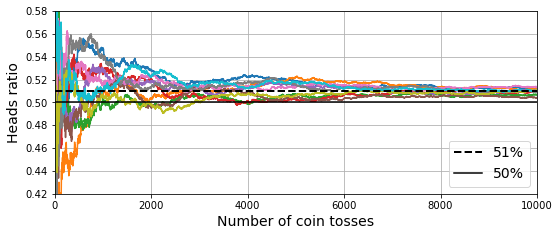

In [5]:
# extra code – this cell generates and saves Figure 7–3

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

Scikit-Learn provides a `VotingClassifier` class that’s quite easy to use: just give it a list of name/predictor pairs, and use it like a normal classifier. Let’s try it on the moons dataset (introduced in Chapter 5). We will load and split the moons dataset into a training set and a test set, then we’ll create and train a voting classifier composed of three diverse classifiers:

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

When you fit a `VotingClassifier`, it clones every estimator and fits the clones. The original estimators are available via the `estimators` attribute, while the fitted clones are available via the `estimators_` attribute. If you prefer a dict rather than a list, you can use `named_estimators` or `named_estimators_` instead. To begin, let’s look at each fitted classifier’s accuracy on the test set:

In [7]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [8]:
voting_clf.predict(X_test[:1])

array([1])

In [9]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

Now let’s look at the performance of the voting classifier on the test set:



In [10]:
voting_clf.score(X_test, y_test)

0.912

There you have it! The voting classifier outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities (i.e., if they all have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called `soft voting`. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is set the voting classifier’s `voting` hyperparameter to `"soft"`, and ensure that all classifiers can estimate class probabilities. This is not the case for the `SVC` class by default, so you need to set its `probability` hyperparameter to `True` (this will make the `SVC` class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method). Let’s try that:

In [11]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

We reach 92% accuracy simply by using soft voting—not bad!



# Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor but train them on different random subsets of the training set. When sampling is performed _with replacement_,⁠ this method is called `bagging`⁠ (short for `bootstrap aggregating⁠`). When sampling is performed _without replacement_, it is called `pasting`.⁠

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. This sampling and training process is represented in Figure below.

![Bagging and pasting involve training several predictors on different random samples of the training set
](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0704.png)

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. **The aggregation function is typically the `statistical mode` for classification (i.e., the most frequent prediction, just like with a hard voting classifier), or the average for regression.** Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation _reduces both bias and variance.⁠_ Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

As you can see in Figure above, predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons bagging and pasting are such popular methods: they scale very well.


## Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting: `BaggingClassifier` class (or `BaggingRegressor` for regression). The following code trains an ensemble of 500 decision tree classifiers:⁠6 each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set `bootstrap=False`). The `n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions, and `–1` tells Scikit-Learn to use all available cores:







In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
---

**NOTE**

A `BaggingClassifier` automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case with decision tree classifiers.

---


Figure below compares the decision boundary of a single decision tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset. As you can see, the ensemble’s predictions will likely generalize much better than the single decision tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

Bagging introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance is reduced. Overall, bagging often results in better models, which explains why it’s generally preferred. But if you have spare time and CPU power, you can use cross-validation to evaluate both bagging and pasting and select the one that works best.


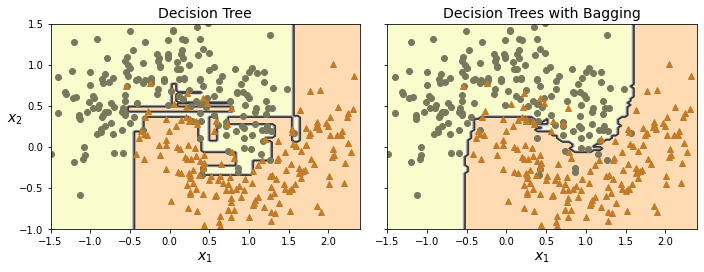

In [13]:
# extra code – this cell generates and saves Figure 7–5

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag evaluation

With bagging, some training instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a `BaggingClassifier` samples `m` training instances with replacement (`bootstrap=True`), where `m` is the size of the training set. With this process, it can be shown mathematically that only about 63% of the training instances are sampled on average for each predictor.⁠ The remaining 37% of the training instances that are not sampled are called `out-of-bag (OOB)` instances. Note that they are not the same 37% for all predictors.


---
**Calculation**

If you randomly draw one instance from a dataset of size _m_, each instance in the dataset obviously has probability 1/_m_ of getting picked, and therefore it has a probability 1 – 1/_m_ of _not_ getting picked. If you draw _m_ instances with replacement, all draws are independent and therefore each instance has a probability (1 – 1/_m_)<sup>_m_</sup> of _not_ getting picked. Now let's use the fact that exp(_x_) is equal to the limit of (1 + _x_/_m_)<sup>_m_</sup> as _m_ approaches infinity. So if _m_ is large, the ratio of out-of-bag instances will be about exp(–1) ≈ 0.37. So roughly 63% (1 – 0.37) will be sampled.

---



In [ ]:
# extra code – shows how to compute the 63% proba
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))


A bagging ensemble can be evaluated using OOB instances, without the need for a separate validation set: indeed, if there are enough estimators, then each instance in the training set will likely be an OOB instance of several estimators, so these estimators can be used to make a fair ensemble prediction for that instance. Once you have a prediction for each instance, you can compute the ensemble’s prediction accuracy (or any other metric).

In Scikit-Learn, you can set `oob_score=True` when creating a `BaggingClassifier` to request an automatic OOB evaluation after training. The following code demonstrates this. The resulting evaluation score is available in the `oob_score_` attribute:

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

The OOB decision function for each training instance is also available through the `oob_decision_function_ `attribute. Since the base estimator has a `predict_proba()` method, the decision function returns the class probabilities for each training instance. For example, the OOB evaluation estimates that the first training instance has a 67.6% probability of belonging to the positive class and a 32.4% probability of belonging to the negative class:

In [15]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

According to this OOB evaluation, this `BaggingClassifier` is likely to achieve about 89.6% accuracy on the test set. Let’s verify this:

In [16]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

We get 92% accuracy on the test. The OOB evaluation was a bit too pessimistic, just over 2% too low.

### Random Patches and Random Subspaces

The `BaggingClassifier` class supports sampling the `features` as well. Sampling is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as `max_samples` and `bootstrap`, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.

This technique is particularly useful when you are dealing with high-dimensional inputs (such as images), as it can considerably speed up training. Sampling both training instances and features is called the [`random patches method`](https://www.semanticscholar.org/paper/Ensembles-on-Random-Patches-Louppe-Geurts/f5ae0b1b48a21ae9083f670d7043495f067064e4?p2df).⁠ Keeping all training instances (by setting `bootstrap=False` and `max_samples=1.0`) but sampling features (by setting `bootstrap_features` to `True` and/or `max_features` to a value smaller than `1.0`) is called the [`random subspaces method`](https://www.researchgate.net/publication/3192880_The_Random_Subspace_Method_for_Constructing_Decision_Forests).⁠

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.



# Random Forest

As we have discussed, a `random forest⁠` is an ensemble of decision trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can use the `RandomForestClassifier` class, which is more convenient and optimized for decision trees⁠ (similarly, there is a `RandomForestRegressor` class for regression tasks). The following code trains a random forest classifier with 500 trees, each limited to maximum 16 leaf nodes, using all available CPU cores:

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The random forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node (see Chapter 6), it searches for the best feature among a random subset of features. By default, it samples $\sqrt{n}$ features (where n is the total number of features). The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model. So, the following `BaggingClassifier` is equivalent to the previous `RandomForestClassifier`:

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [20]:
# extra code – verifies that the predictions are identical
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # same predictions

True

## Extra-Trees

When you are growing a tree in a random forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular decision trees do). For this, simply set `splitter="random"` when creating a `DecisionTreeClassifier`.

A forest of such extremely random trees is called an `extremely randomized trees` (or `extra-trees` for short) ensemble. Once again, this technique trades more bias for a lower variance. It also makes extra-trees classifiers much faster to train than regular random forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

You can create an extra-trees classifier using Scikit-Learn’s `ExtraTreesClassifier` class. Its API is identical to the `RandomForestClassifier` class, except `bootstrap` defaults to False. Similarly, the `ExtraTreesRegressor` class has the same API as the `RandomForestRegressor` class, except `bootstrap` defaults to False.

---

**TIP**

It is hard to tell in advance whether a `RandomForestClassifier` will perform better or worse than an `ExtraTreesClassifier`. Generally, the only way to know is to try both and compare them using cross-validation.

---


## Feature Importance

Yet another great quality of random forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it (see Chapter 6).

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result using the `feature_importances_` variable. For example, the following code trains a `RandomForestClassifier` on the iris dataset (introduced in Chapter 4) and outputs each feature’s importance. It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively):



In [21]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Similarly, if you train a random forest classifier on the MNIST dataset (introduced in Chapter 3) and plot each pixel’s importance, you get the image represented in Figure below.

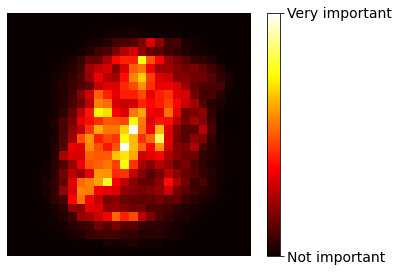

In [22]:
# extra code – this cell generates and saves Figure 7–6

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

Random forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

# Boosting

Boosting (originally called hypothesis boosting) refers to any ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are [AdaBoost](https://www.sciencedirect.com/science/article/pii/S002200009791504X). (short for adaptive boosting) and gradient boosting. Let’s start with AdaBoost.

## AdaBoost
One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfit. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a decision tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on (see Figure below).

![ AdaBoost sequential training with instance weight updates
](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0707.png)



Figure below shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel).⁠ The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. The plot on the right represents the same sequence of predictors, except that the learning rate is halved (i.e., the misclassified instance weights are boosted much less at every iteration). As you can see, this sequential learning technique has some similarities with gradient descent, except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

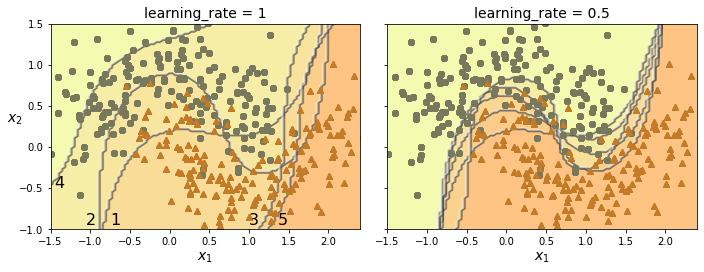

In [23]:
# extra code – this cell generates and saves Figure 7–8

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

---
**WARNING**

There is one important drawback to this sequential learning technique: training cannot be parallelized since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.

---

### Adaboost Algorithm (optional)


Let's take a closer look at the AdaBoost algorithm. Each instance weight $w^{(i)}$ is initially set to $1/m$. A first predictor is trained, and its weighted error rate $r_i$ is computed on the training set; see Equation 7-1.

**Equation 7-1. Weighted error rate of the $j^{th}$ predictor**

$$
r_j = \sum_{\substack{i=1\\\hat{y}_j^{(i)} \ne y^{(i)}  }}^m w^{(i)}
$$

where $\hat{y}_j^{(i)}$ is the $j^{th}$ predictor's prediction for the $i^{th}$ instance.

The predictor's weight $\alpha_j$ is then computed using Equation 7-2, where $\eta$ is the learning rate hyperparameter (defaults to 1). The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

**Equation 7-2. Predictor weight**

$$
\alpha_j = \eta \log \frac{1 - r_j}{r_j}
$$

Next, the AdaBoost algorithm updates the instance weights, using Equation 7-3, which boosts the weights of the misclassified instances.

**Equation 7-3. Weight update rule**

$$
\text{for } i = 1,2,\ldots,m
$$

$$
w^{(i)} \leftarrow w^{(i)} \exp (\alpha_j) \quad \text{if } \hat{y}_j^{(i)} \ne y^{(i)}
$$
$$
w^{(i)} \leftarrow w^{(i)} \quad \text{if } \hat{y}_j^{(i)} = y^{(i)}
$$

Then all the instance weights are normalized (i.e., divided by $\sum_{i=1}^m w^{(i)}$).

Finally, a new predictor is trained using the updated weights, and the whole process is repeated: the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on. The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes (see Equation 7-4).

**Equation 7-4. AdaBoost predictions**

$$
\hat{y} (\mathbf{x}) = \arg\max_k \sum_{\substack{j=1 \\  \hat{y}_j (\mathbf{x}) = k }}^N \alpha_j 
$$

where $N$ is the number of predictors.




Scikit-Learn uses a multiclass version of AdaBoost called _SAMME_⁠ (which stands for _Stagewise Additive Modeling using a Multiclass Exponential loss function_). When there are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate class probabilities (i.e., if they have a `predict_proba()` method), Scikit-Learn can use a variant of SAMME called _SAMME.R_ (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.

The following code trains an AdaBoost classifier based on 30 decision stumps using Scikit-Learn’s `AdaBoostClassifier` class (as you might expect, there is also an AdaBoostRegressor class). A decision stump is a decision tree with `max_depth=1`—in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the `AdaBoostClassifier` class:

In [24]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

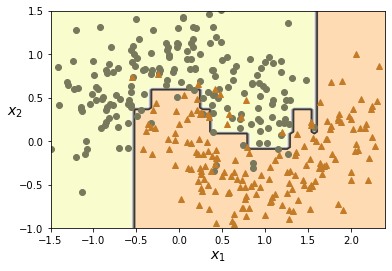

In [25]:
# extra code – in case you're curious to see what the decision boundary
#              looks like for the AdaBoost classifier
plot_decision_boundary(ada_clf, X_train, y_train)

---

**TIP**

If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.

---


## Gradient Boosting

Another very popular boosting algorithm is `gradient boosting`.⁠ Just like AdaBoost, gradient boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the **residual errors** made by the previous predictor.

Let’s go through a simple regression example, using decision trees as the base predictors; this is called `gradient tree boosting`, or `gradient boosted regression trees (GBRT)`. First, let’s generate a noisy quadratic dataset and fit a `DecisionTreeRegressor` to it:




In [26]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now let's train a second `DecisionTreeRegressor` on the residual errors made by the previous predictor:

In [27]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

And then we’ll train a third regressor on the residual errors made by the second predictor:

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [29]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

Figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

You can use Scikit-Learn’s `GradientBoostingRegressor` class to train GBRT ensembles more easily (there’s also a `GradientBoostingClassifier` class for classification). Much like the `RandomForestRegressor` class, it has hyperparameters to control the growth of decision trees (e.g., `max_depth`, `min_samples_leaf`), as well as hyperparameters to control the ensemble training, such as the number of trees (`n_estimators`). The following code creates the same ensemble as the previous one:

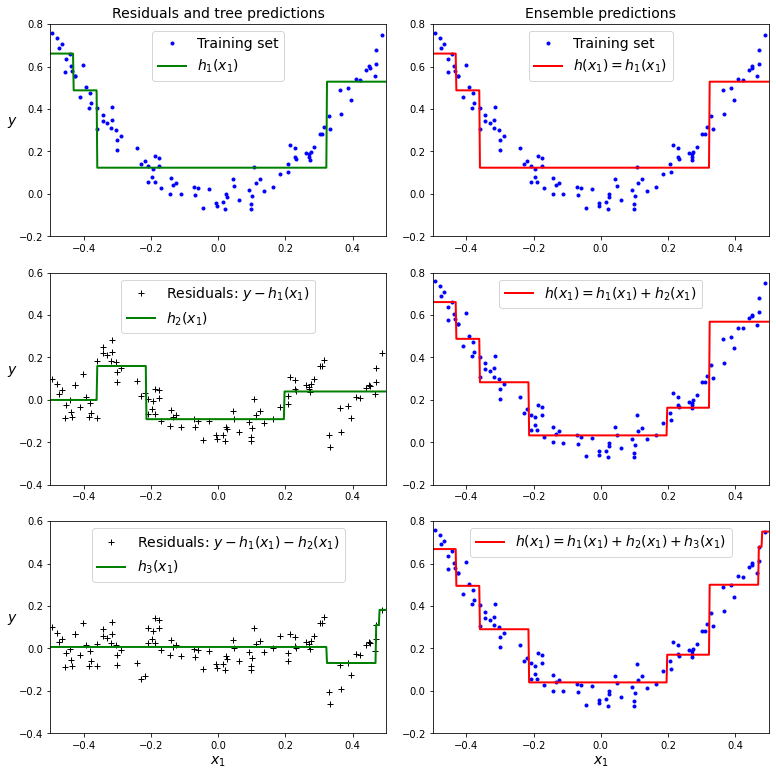

In [30]:
# extra code – this cell generates and saves Figure 7–9

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

To find the optimal number of trees, you could perform cross-validation using `GridSearchCV `or `RandomizedSearchCV`, as usual, but there’s a simpler way: if you set the `n_iter_no_change` hyperparameter to an integer value, say 10, then the `GradientBoostingRegressor` will automatically stop adding more trees during training if it sees that the last 10 trees didn’t help. This is simply early stopping (introduced in Chapter 4), but with a little bit of patience: it tolerates having no progress for a few iterations before it stops. Let’s train the ensemble using early stopping:

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [32]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

If you set `n_iter_no_change` too low, training may stop too early and the model will underfit. But if you set it too high, it will overfit instead. We also set a fairly small learning rate and a high number of estimators, but the actual number of estimators in the trained ensemble is much lower, thanks to early stopping:

In [33]:
gbrt_best.n_estimators_

92

The `learning_rate` hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.05, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called _shrinkage_. Figure below shows two GBRT ensembles trained with different hyperparameters: the one on the left does not have enough trees to fit the training set, while the one on the right has about the right amount. If we added more trees, the GBRT would start to overfit the training set.

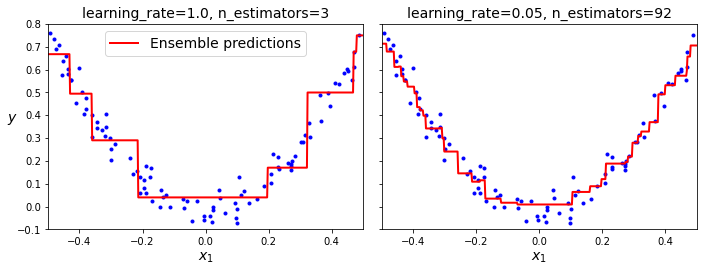

In [34]:
# extra code – this cell generates and saves Figure 7–10

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

When `n_iter_no_change` is set, the `fit()` method automatically splits the training set into a smaller training set and a validation set: this allows it to evaluate the model’s performance each time it adds a new tree. The size of the validation set is controlled by the `validation_fraction` hyperparameter, which is 10% by default. The `tol` hyperparameter determines the maximum performance improvement that still counts as negligible. It defaults to 0.0001.

The `GradientBoostingRegressor` class also supports a `subsample` hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if `subsample=0.25`, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, this technique trades a higher bias for a lower variance. It also speeds up training considerably. This is called `stochastic gradient boosting`.

## Histogram-Based Gradient Boosting

Scikit-Learn also provides another GBRT implementation, optimized for large datasets: `histogram-based gradient boosting (HGB)`. It works by binning the input features, replacing them with integers. The number of bins is controlled by the `max_bins` hyperparameter, which defaults to 255 and cannot be set any higher than this. Binning can greatly reduce the number of possible thresholds that the training algorithm needs to evaluate. Moreover, working with integers makes it possible to use faster and more memory-efficient data structures. And the way the bins are built removes the need for sorting the features when training each tree.

As a result, this implementation has a computational complexity of `O(b×m)` instead of `O(n×m×log(m))`, where b is the number of bins, m is the number of training instances, and n is the number of features. In practice, this means that HGB can train hundreds of times faster than regular GBRT on large datasets. However, binning causes a precision loss, which acts as a regularizer: depending on the dataset, this may help reduce overfitting, or it may cause underfitting.

Scikit-Learn provides two classes for HGB: `HistGradientBoostingRegressor` and `HistGradientBoostingClassifier`. They’re similar to `GradientBoostingRegressor` and `GradientBoostingClassifier`, with a few notable differences:

- Early stopping is automatically activated if the number of instances is greater than 10,000. You can turn early stopping always on or always off by setting the `early_stopping` hyperparameter to `True` or `False`.

- Subsampling is not supported.

- `n_estimators` is renamed to `max_iter`.

- The only decision tree hyperparameters that can be tweaked are `max_leaf_nodes`, `min_samples_leaf`, and `max_depth`.

The HGB classes also have two nice features: they support both categorical features and missing values. This simplifies preprocessing quite a bit. However, the categorical features must be represented as integers ranging from 0 to a number lower than `max_bins`. You can use an `OrdinalEncoder` for this. For example, here’s how to build and train a complete pipeline for the California housing dataset introduced in Chapter 2:

In [35]:
# extra code – at least not in this chapter, it's presented in chapter 2

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder 

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [37]:
# extra code – evaluate the RMSE stats for the hgb_reg model

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

The whole pipeline is just as short as the imports! No need for an imputer, scaler, or a one-hot encoder, so it’s really convenient. Note that `categorical_features` must be set to the categorical column indices (or a Boolean array). Without any hyperparameter tuning, this model yields an RMSE of about 47,600, which is not too bad.


---

**TIP**

Several other optimized implementations of gradient boosting are available in the Python ML ecosystem: in particular, `XGBoost`, `CatBoost`, and `LightGBM`. These libraries have been around for several years. They are all specialized for gradient boosting, their APIs are very similar to Scikit-Learn’s, and they provide many additional features, including GPU acceleration; you should definitely check them out! Moreover, the TensorFlow Random Forests library provides optimized implementations of a variety of random forest algorithms, including plain random forests, extra-trees, GBRT, and several more.

---


# Stacking

The last ensemble method we will discuss in this chapter is called `stacking` (short for stacked generalization).⁠ It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation? Figure below shows such an ensemble performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a `blender`, or a `meta learner`) takes these predictions as inputs and makes the final prediction (3.0).

![Aggregating predictions using a blending predictor](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0711.png)


To train the blender, you first need to build the blending training set. You can use cross_val_predict() on every predictor in the ensemble to get out-of-sample predictions for each instance in the original training set (Figure below), and use these can be used as the input features to train the blender; and the targets can simply be copied from the original training set. Note that regardless of the number of features in the original training set (just one in this example), the blending training set will contain one input feature per predictor (three in this example). Once the blender is trained, the base predictors are retrained one last time on the full original training set.

![Training the blender in a stacking ensemble](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0712.png)

It is actually possible to train several different blenders this way (e.g., one using linear regression, another using random forest regression) to get a whole layer of blenders, and then add another blender on top of that to produce the final prediction, as shown in Figure 7-13. You may be able to squeeze out a few more drops of performance by doing this, but it will cost you in both training time and system complexity.


![Predictions in a multilayer stacking ensemble
](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0713.png)


Scikit-Learn provides two classes for stacking ensembles: `StackingClassifier` and `StackingRegressor`. For example, we can replace the `VotingClassifier` we used at the beginning of this chapter on the moons dataset with a `StackingClassifier`:

In [38]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [39]:
stacking_clf.score(X_test, y_test)

0.928

For each predictor, the stacking classifier will call `predict_proba()` if available; if not it will fall back to `decision_function()` or, as a last resort, call `predict()`. If you don’t provide a final estimator, `StackingClassifier` will use `LogisticRegression` and `StackingRegressor` will use `RidgeCV`.

If you evaluate this stacking model on the test set, you will find 92.8% accuracy, which is a bit better than the voting classifier using soft voting, which got 92%.

In conclusion, ensemble methods are versatile, powerful, and fairly simple to use. Random forests, AdaBoost, and GBRT are among the first models you should test for most machine learning tasks, and they particularly shine with heterogeneous tabular data. Moreover, as they require very little preprocessing, they’re great for getting a prototype up and running quickly. Lastly, ensemble methods like voting classifiers and stacking classifiers can help push your system’s performance to its limits.